### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery (i.e., simulations, model fitting) for a general linear model with discounting of previous values of Xn by gamma (i.e., `Y ~ b0 + gamma^0 * b1*X1_t + gamma^1 * b1*X1_{t-1} + gamma^2 * b1*X1_{t-2} + ...`)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle, datetime
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')
from pyEM.fitting import EMfit
from pyEM.math import compGauss_ms, norm2alpha
from pyEM import plotting
import glm_models

In [4]:
modelID = 'GLM'
param_names = ['b0', 'b1', 'b2', 'b3', 'gamma']
objfunc_dict = {modelID: glm_models.fit_decay}
simul_dict   = {modelID: glm_models.simulate_decay}

nparams = len(param_names)
nsubjects = 150
params = np.ones((nsubjects, nparams))
for simS in tqdm(range(nsubjects)):
    for parP in range(nparams):
        # we will sample from a normal distribution
        if parP == 4:
            # keep gamma between 0 and 1
            params[simS, parP] = norm.rvs(0.5, scale=0.2)
            while params[simS, parP] < 0 or params[simS, parP] > 1:
                params[simS, parP] = norm.rvs(0.5, scale=0.2)
        else:
            params[simS, parP] = norm.rvs(0, scale=1)

100%|██████████| 150/150 [00:00<00:00, 5768.11it/s]


In [5]:
simulfunc = simul_dict['GLM']
ntrials = 100
X, Y = simulfunc(params, ntrials)

In [6]:
# create a list of lists with X, Y for each subject
all_data = []
for subject_idx in range(nsubjects):
    thisX = X[subject_idx,:,:]
    thisY = Y[subject_idx,:]
    all_data += [[thisX, thisY]]

In [7]:
output_dict = EMfit(all_data, objfunc_dict['GLM'], param_names)

m, inv_h, posterior, NPL, NLPrior, NLL, convergence = output_dict.values()

31733.120 (000), 20656.812 (001), 20649.972 (002), 20649.267 (003), 20649.153 (004), 20649.132 (005), 20649.121 (006),  -- CONVERGED!!!!!


In [14]:
## Now store all relevant outputs in modout dict and save it
save_fit = False

# get covariance matrix
_, _, _, covmat_out = compGauss_ms(m,inv_h,2)
nparams = len(param_names)

# Fill in general information
modout = {}
modout[modelID] = {}
modout[modelID]['date'] = datetime.date.today().strftime('%Y%m%d')

# Fill in fit information
est_params = m.T.copy()
for subj_idx in range(nsubjects):
    for param_idx, param_name in enumerate(param_names):
        if 'gamma' in param_name:
            est_params[subj_idx, param_idx] = norm2alpha(m[param_idx, subj_idx])
        else:
            est_params[subj_idx, param_idx] = m[param_idx, subj_idx]

modout[modelID]['fit'] = {}
modout[modelID]['fit']['norm_params'] = m
modout[modelID]['fit']['params'] = est_params
modout[modelID]['fit']['param_names'] = param_names
modout[modelID]['fit']['inverse_hess'] = inv_h
modout[modelID]['fit']['gauss.mu'] = posterior['mu']
modout[modelID]['fit']['gauss.sigma'] = posterior['sigma']
modout[modelID]['fit']['gauss.cov'] = covmat_out
try:
    modout[modelID]['fit']['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modout[modelID]['fit']['gauss.corr'] = np.eye(nparams)
modout[modelID]['fit']['npl'] = NPL  # note: this is the negative joint posterior likelihood
modout[modelID]['fit']['NLPrior'] = NLPrior
modout[modelID]['fit']['nll'] = NPL - NLPrior

# Make sure you know if BIC is positive or negative! and replace lme with
# bic if covariance is negative.
# Error check that BICs are in a similar range
# Get subject specifics
goodHessian = np.zeros(nsubjects)
modout[modelID]['fit']['predicted_y'] = np.zeros((nsubjects, ntrials))
modout[modelID]['fit']['negll'] = np.zeros((nsubjects,))
modout[modelID]['fit']['BIC'] = np.zeros((nsubjects,))

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
for subj_idx in range(nsubjects):    
    model_fits = glm_models.fit_decay(m[:,subj_idx], X[subj_idx,:,:], Y[subj_idx], prior=None, output='all')

    # store model fits
    modout[modelID]['fit']['predicted_y'][subj_idx] = model_fits['predicted_y']
    modout[modelID]['fit']['negll'][subj_idx] = model_fits['negll']
    modout[modelID]['fit']['BIC'][subj_idx] = model_fits['BIC']

# Save output
if save_fit:
    with open(f'EMfit_{modelID}.pkl', 'wb') as f:
        pickle.dump(modout, f)

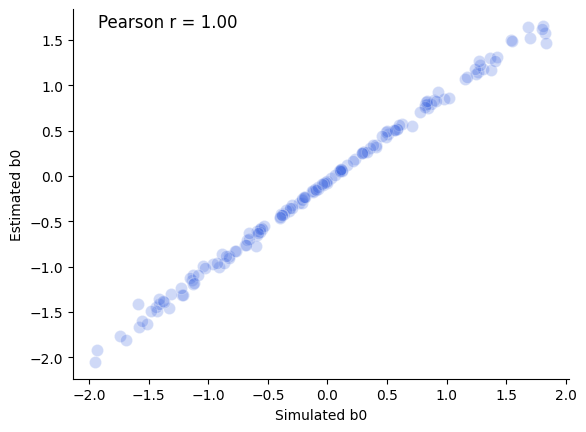

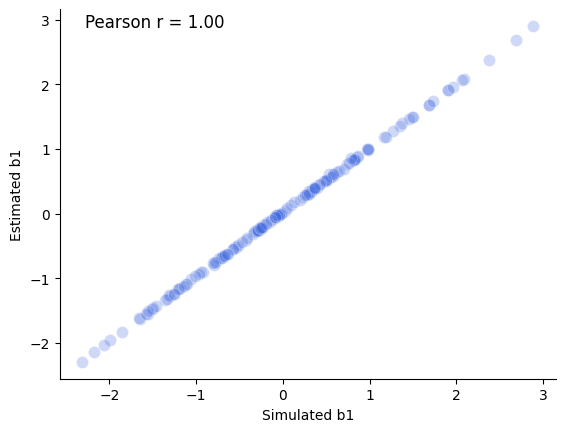

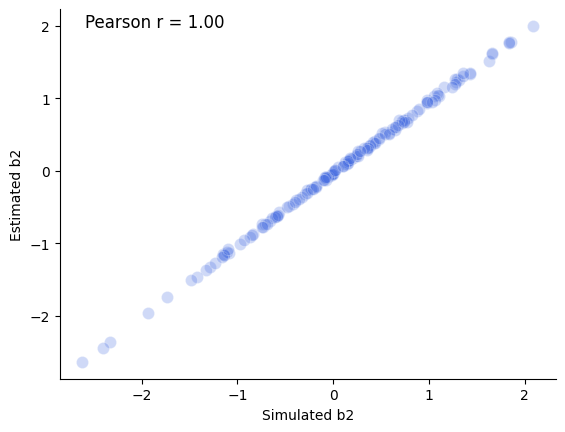

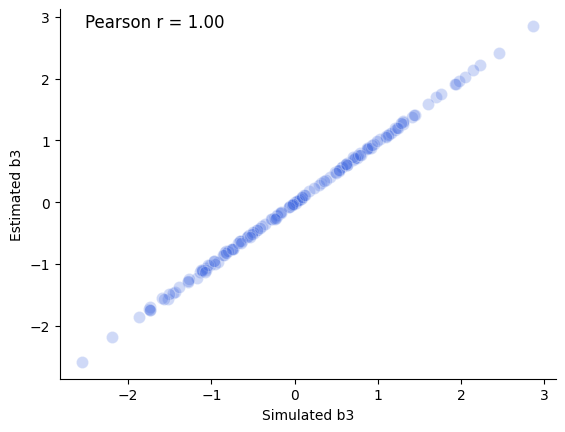

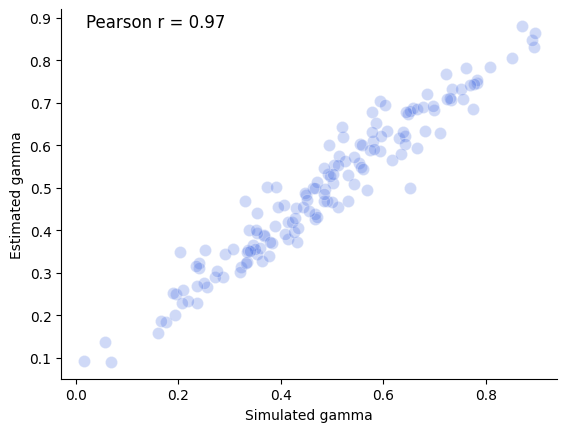

In [15]:
for param_idx, param_label in enumerate(param_names):
    simulated_param = params[:,param_idx]
    fitted_params = est_params[:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

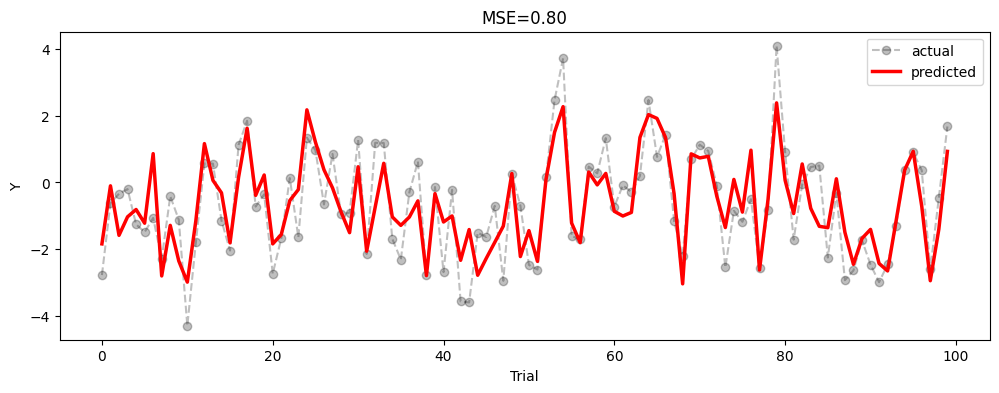

In [16]:
# plot y vs predicted y over trials for a single subject
subject_test = 42
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(Y[subject_test], color='black', marker='o', linestyle='--', alpha=0.25, label='actual')
plt.plot(modout[modelID]['fit']['predicted_y'][subject_test], color='red', label='predicted', linewidth=2.5)
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Y')
# annotate with MSE
mse = np.mean((Y[subject_test] - modout[modelID]['fit']['predicted_y'][subject_test])**2)
plt.title(f'MSE={mse:.2f}')
plt.show()